In [16]:
import numpy as np
from nn import nn # Import your NeuralNetwork class
from nn import preprocess
from nn import io
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


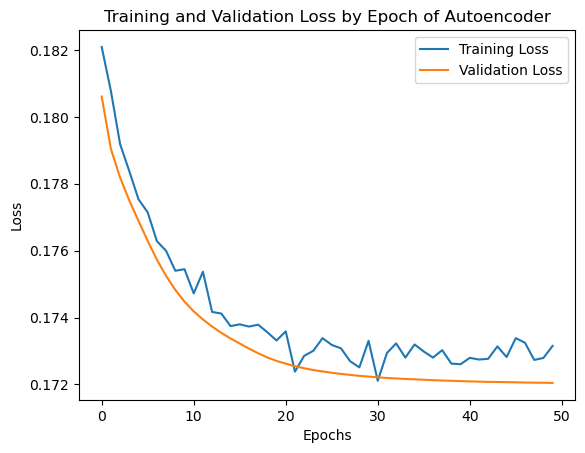

Average Reconstruction Error: 0.172046


In [17]:
# Load the digits dataset
digits = load_digits()
X = digits.data  # Shape (1797, 64)

# Normalize pixel values to [0,1] range
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into training and validation sets
X_train, X_val = train_test_split(X, test_size=0.8, random_state=42)


# Define the autoencoder architecture
autoencoder_arch = [
    {"input_dim": 64, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 64, "activation": "sigmoid"}
]

# Initialize the neural network model
autoencoder = nn.NeuralNetwork(
    nn_arch=autoencoder_arch,
    lr=0.01,
    seed=42,
    batch_size=32,
    epochs=50,
    loss_function="mean_squared_error"
)

# Train the autoencoder
train_loss, val_loss = autoencoder.fit(X_train, X_train, X_val, X_val)

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss by Epoch of Autoencoder')
plt.show()

# Compute average reconstruction error on validation set
X_val_reconstructed = autoencoder.predict(X_val)
reconstruction_error = np.mean(np.power(X_val - X_val_reconstructed, 2))
print(f'Average Reconstruction Error: {reconstruction_error:.6f}')


The activation function is ReLu for each hidden layer and is sigmoid for the output layer.
A learning rate (0.01) is chosen for moderate training speed without overshooting.
A batch size of 32 is a small batch size that ensures smoother updates to weights.
50 epochs provides enough training for convergence.
The loss function of MSE is used for autoencoder reconstruction error and is the appropriate choice to measure the autoencoder's performance.

In [18]:
pos_seqs = io.read_text_file("data/rap1-lieb-positives.txt")
neg_seqs = io.read_fasta_file("data/yeast-upstream-1k-negative.fa")

labels = ([True] * len(pos_seqs)) + [False] * (len(neg_seqs))

all_seqs = pos_seqs + neg_seqs
sampled_seqs, sampled_labels = preprocess.sample_seqs(all_seqs, labels)

sampled_one_hot_seqs = (preprocess.one_hot_encode_seqs(sampled_seqs))

max_len = 0
for row in sampled_one_hot_seqs:
    seq_len = len(row)
    if seq_len > max_len:
        max_len = seq_len

padded_one_hot_seqs = []

for row in sampled_one_hot_seqs:
    seq_len = len(row)
    pad_length = max_len - seq_len
    pad = [2] * pad_length
    row = row + pad
    padded_one_hot_seqs.append(row)


converted_labels = np.array(sampled_labels, dtype=int)
X = np.asarray(padded_one_hot_seqs)
y = converted_labels


The sampling scheme used to balance the classes implements oversampling the class (positive or negative) that is less represented. For example, if there are fewer negative samples, my algorithm samples with replacement from the negatively labeled sequences until the number of positive and negative samples are equal. Oversampling means that all information will be present, even if it is overrepresented. If I were to remove samples to balance the classes, there would be a potential of losing sequence information.

The input dimension of the first layer matches the number of features for each input. The output dimension matches the batch size. The second layer has an output dimension of 1 to provide a single predicted value for each input. The activation function is ReLu for each hidden layer and is sigmoid for the output layer.
A learning rate (0.001) is chosen for moderate training speed without overshooting.
A batch size of 32 is a small batch size that ensures smoother updates to weights.
50 epochs provides enough training for convergence.
The loss function of binary cross entropy is used for to measure the error of binary classification.

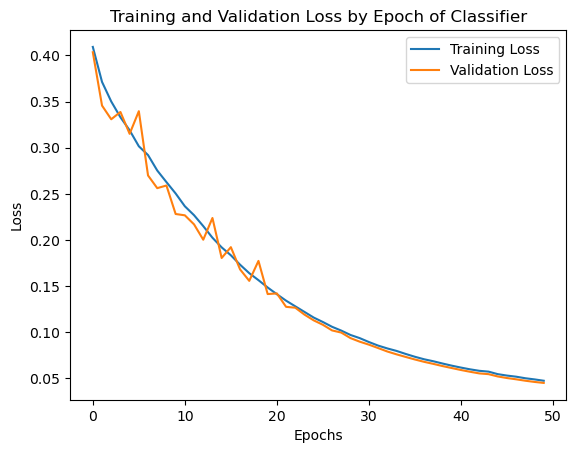

Accuracy of predicated labels for validation set:
1.0


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Ensure y is a column vector
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
# Define the neural network architecture
nn_architecture = [
    {'input_dim': 4000, 'output_dim': 32, 'activation': 'relu'},
    {'input_dim': 32, 'output_dim': 1, 'activation': 'sigmoid'}
]

# Set hyperparameters
learning_rate = 0.001
random_seed = 42
batch_size = 32
max_epochs = 50
loss_function = 'binary_cross_entropy'  # Appropriate for binary classification

# Initialize the model
classifier = nn.NeuralNetwork(
    nn_arch=nn_architecture,
    lr=learning_rate,
    seed=random_seed,
    batch_size=batch_size,
    epochs=max_epochs,
    loss_function=loss_function
)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Train the model
train_loss, val_loss = classifier.fit(X_train, y_train, X_val, y_val)


# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss by Epoch of Classifier')
plt.show()

# Make predictions
y_pred = classifier.predict(X_val)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions


accurate = 0
for i in range(len(y_val)):
    if y_val[i] == y_pred_binary[i]:
        accurate += 1
print("Accuracy of predicated labels for validation set:")
print (accurate/len(y_val))